In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous
print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(21421, 25)
(21421, 3)


In [6]:
X_motion_CoM_continuous[0]

array([0.1, 0.0, 0.0, 0.028489577089618634, -0.029145302018442662,
       0.022371074929438357, -0.0008381898040188694, 0.0231294258002537,
       0.009549917970638715, 0.22305503249962916, 0.17312669533899627,
       -0.4095482720203519, 0.23991911170027655, -0.1660954835575981,
       -0.4097740078763965, -0.23724878115057912, 0.16637246153782909,
       -0.4126119486139448, -0.25387675804380694, -0.1600415552684769,
       -0.41301528981091734, True, False, False, True], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM_continuous[:, 21] == 1)[0]
X_motion_CoM_continuous_FL_RR = X_motion_CoM_continuous[idx_fl_rr_swinging]
Y_motion_CoM_continuous_FL_RR = Y_motion_CoM_continuous[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(10693,)

## Predict CoM -> x

In [10]:
X_motion_CoM_continuous_FL_RR[0, :]

array([0.1, 0.0, 0.0, 0.028489577089618634, -0.029145302018442662,
       0.022371074929438357, -0.0008381898040188694, 0.0231294258002537,
       0.009549917970638715, 0.22305503249962916, 0.17312669533899627,
       -0.4095482720203519, 0.23991911170027655, -0.1660954835575981,
       -0.4097740078763965, -0.23724878115057912, 0.16637246153782909,
       -0.4126119486139448, -0.25387675804380694, -0.1600415552684769,
       -0.41301528981091734, True, False, False, True], dtype=object)

In [11]:
Y_motion_CoM_continuous_FL_RR[0, :]

array([0.006780646577309566, 0.0017755153220013614, 0.0020288801331269663],
      dtype=object)

### Linear Regression

In [34]:
# Input
X = np.hstack((X_motion_CoM_continuous_FL_RR[:, :3], # motion command
               X_motion_CoM_continuous_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 18:20])) # RR (x,y) position 

# Labels
Y = np.array([Y_motion_CoM_continuous_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9913814719065464
RMSE:  0.002048274906483232
The lowest error is:  4.3129764940030846e-07
The highest error is:  0.03046597438043222
The avg. error is:  0.001278898008668906


In [35]:
model_fl_com_x.coef_

array([[ 0.20376512,  0.02402254,  0.0052527 ,  0.11267386, -0.07684928,
        -0.02902223, -0.24131625, -0.3580533 ,  0.03526293,  0.05176114,
         0.04349473]])

In [38]:
model_fl_com_x.intercept_

array([-0.12857186])

Text(0, 0.5, 'Predictions')

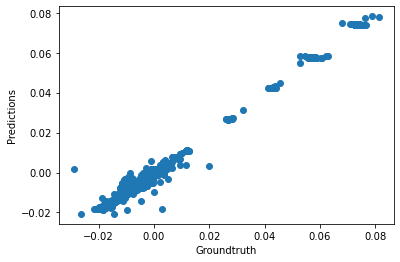

In [39]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [19]:
#%store model_fl_com_x

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [52]:
# Input
X = np.hstack((X_motion_CoM_continuous_FL_RR[:, :3], # motion command
               X_motion_CoM_continuous_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 18:20])) # RR (x,y) position 

# Labels
Y = np.array([Y_motion_CoM_continuous_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.99898822494589
RMSE:  0.001535290423318354
The lowest error is:  3.972508860888846e-07
The highest error is:  0.026354475071101127
The avg. error is:  0.0009738573870020621


In [53]:
model_fl_com_y.coef_

array([[ 0.05278749,  0.15672529,  0.14916124, -0.08732666,  0.16653137,
        -0.18461004,  0.0219723 , -0.36701152,  0.26234807,  0.08219048,
         0.33983785]])

In [54]:
model_fl_com_y.intercept_

array([-0.01893889])

Text(0, 0.5, 'Predictions')

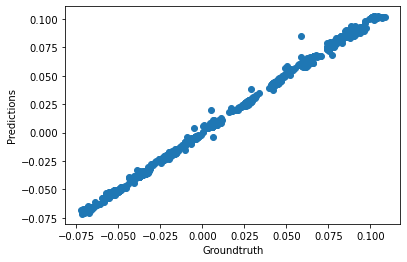

In [55]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [67]:
#%store model_fl_com_y

In [68]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [69]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")